# Analysis and Visualization of Complex Agro-Environmental Data
---
### Exercise #10 - correction

In [85]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

Exercise 10.1 - Run a PCA based on quantitative environmental variables (see previous exercise), using sites from the Douro and Tejo, Mondego and Minho basins. Produce a biplot with ‘Catchment_name’ as a grouping variable.

In [86]:
df = pd.read_csv('../Exemplos/EFIplus_medit.zip',compression='zip', sep=";")
df = df.dropna() # remove all rows with missing data
# Subset the df by selecting the environmental variables and the species richness columns
dfsub = df[(df['Catchment_name']=='Douro') | (df['Catchment_name']=='Tejo') | (df['Catchment_name']=='Mondego') | (df['Catchment_name']=='Minho')]
df_env = dfsub[["Altitude", "Actual_river_slope","Elevation_mean_catch", "prec_ann_catch","temp_ann","temp_jan","temp_jul"]]
df_catch = dfsub[["Catchment_name"]]

In [87]:
efi_scaled = StandardScaler().fit_transform(df_env)
# As a result, we obtained a two-dimensional NumPy array. We can convert it to a pandas DataFrame for a better display.
df_scaled = pd.DataFrame(data=efi_scaled, 
                                columns=df_env.columns)
df_scaled.head()

,Altitude,Actual_river_slope,Elevation_mean_catch,prec_ann_catch,temp_ann,temp_jan,temp_jul
0,2.317434,-0.792732,2.286957,-1.089865,-1.749363,-1.868883,-0.917168
1,1.853915,-0.676045,1.253702,-1.815993,-1.236037,-1.548490,-0.331631
2,0.532391,-0.779186,0.398903,-2.433332,-0.209383,-0.907706,0.497880
3,1.367384,-0.642389,0.716150,-2.252746,-0.862708,-1.348245,0.107522
4,1.308211,-0.610283,0.445796,-2.411039,-0.909374,-1.388294,-0.136452


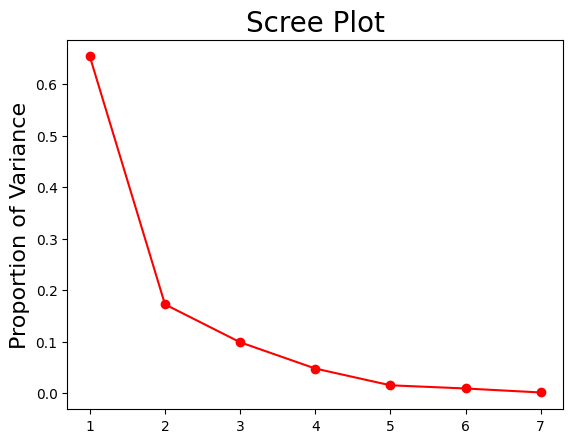

In [88]:
# select number of PCs
pca = PCA(n_components=7)
pca.fit_transform(df_scaled)
eigenvalues = pca.explained_variance_ # eigenvalues
prop_var = pca.explained_variance_ratio_ # proportion of explained variance

# Scree Plot
PC_numbers = np.arange(pca.n_components_) + 1
 
plt.plot(PC_numbers, 
         prop_var,
         'ro-')
plt.title('Scree Plot', fontsize=20)
plt.ylabel('Proportion of Variance', fontsize=16)
plt.show()

In [89]:
pca = PCA(n_components=2)
PC = pca.fit_transform(df_scaled)
pca_efi = pd.DataFrame(data = PC, 
                            columns = ['PC1', 'PC2'])
pca_efi.head(6)

,PC1,PC2
0,3.682106,-2.345615
1,2.383697,-2.633798
2,0.269847,-2.766732
3,1.471039,-2.812037
4,1.456941,-2.835882
5,0.457595,-2.874873


Text(0, 0.5, 'PC2')

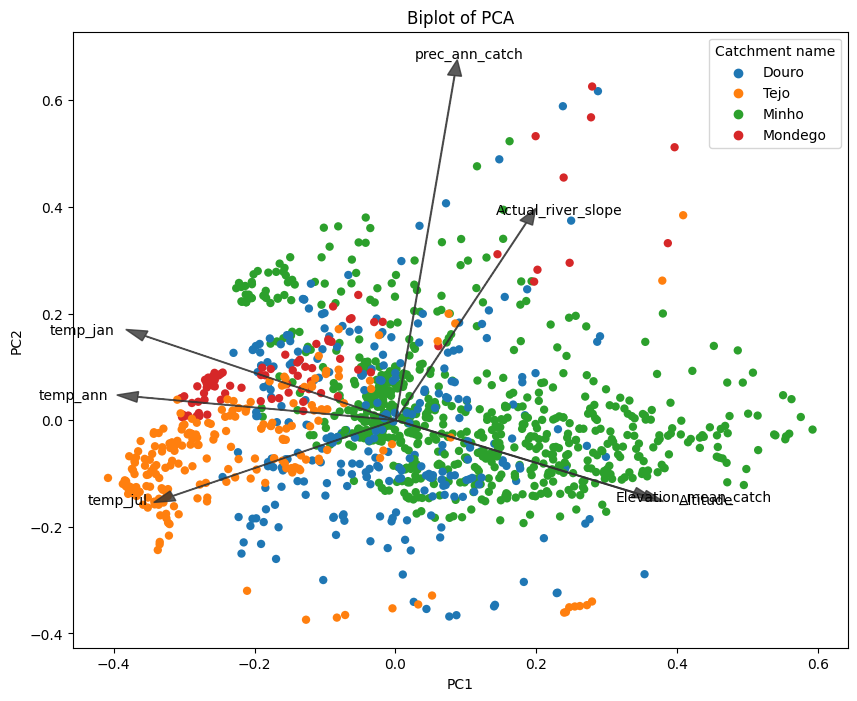

In [90]:
# Biplot
PC1 = pca_efi['PC1']/(pca_efi['PC1'].max() - pca_efi['PC1'].min())
PC2 = pca_efi['PC2']/(pca_efi['PC2'].max() - pca_efi['PC2'].min())

plt.figure(figsize=(10, 8))
plt.title('Biplot of PCA')
sns.scatterplot(x=PC1,
              y=PC2,
              hue = df_catch['Catchment_name'].tolist(),
              linewidth=0,
              )

n = np.transpose(pca.components_).shape[0] # number of dimensions (2)
for i in range(n):
        plt.arrow(0, 0, np.transpose(pca.components_)[i,0]*0.8, 
                  np.transpose(pca.components_)[i,1]*0.8, 
                  color = (0.2, 0.2, 0.2, 0.8),
                  head_width=0.02) # plot arrows for each variable
        plt.text(np.transpose(pca.components_)[i,0]*1, 
                 np.transpose(pca.components_)[i,1]*0.85, 
                 list(df_env.columns)[i], 
                 color = "black", 
                 ha = 'center', 
                 va = 'center') # variable labels for each arrow
plt.legend(title='Catchment name')
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))


Exercise 10.2 - Using the same data, run a PCoA and project the sites using the resulting first two axis. Use also the ‘Catchment_name’ as a grouping variable.

<Axes: >

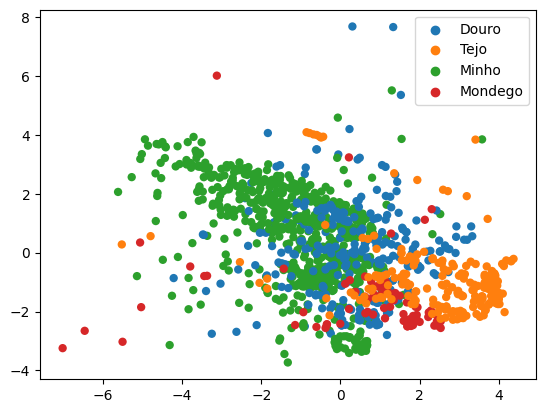

In [91]:
# Run MDS
# by default the 'mds' argument is set to 'True', which means it will run a MDS
# Euclidean distances are also the default 
# Only two axis are extracted by default
mds = MDS(random_state=0, normalized_stress = False) 
mds_transf = mds.fit_transform(df_scaled)
# plot the MDS
sns.scatterplot(x=mds_transf[:,0],
              y=mds_transf[:,1],
              hue = df_catch['Catchment_name'].tolist(),
              linewidth=0,
              )

In [92]:
# Run NMDS
nmds = MDS(n_components=5, metric = False, normalized_stress="auto") # 5 components extracted so that stress is > 0.2
nmds_transf = nmds.fit_transform(df_scaled)


In [93]:
stress = nmds.stress_
print(stress)

0.18617506479433746


<Axes: >

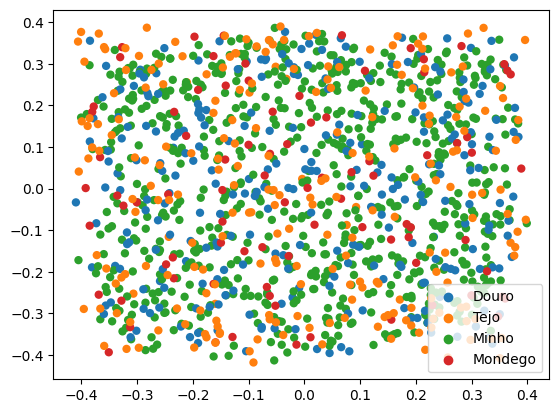

In [94]:
sns.scatterplot(x=nmds_transf[:,0],
              y=nmds_transf[:,1],
              hue = df_catch['Catchment_name'].tolist(),
              linewidth=0,
              )

Exercise 10.3 - . Run a Linear Discriminant Analysis based on quantitative environmental variables (see previous exercises), using the Douro and Tejo basins as the pre-determined groups. Produce a biplot with ‘Catchment_name’ as a grouping variable. 

NOTE: to be more interesting it is better to consider more catchments, so the Minho and Mondego catchments were also considered

In [95]:
df = pd.read_csv('../Exemplos/EFIplus_medit.zip',compression='zip', sep=";")
df = df.dropna() # remove all rows with missing data
# Subset the df by selecting the environmental variables and the species richness columns
dfsub = df[(df['Catchment_name']=='Douro') | (df['Catchment_name']=='Tejo') | (df['Catchment_name']=='Minho') | (df['Catchment_name']=='Mondego')]
df_env = dfsub[["Altitude", "Actual_river_slope","Elevation_mean_catch", "prec_ann_catch","temp_ann","temp_jan","temp_jul"]]
df_catch = dfsub[["Catchment_name"]]

In [96]:
efi_scaled = StandardScaler().fit_transform(df_env)
# As a result, we obtained a two-dimensional NumPy array. We can convert it to a pandas DataFrame for a better display.
df_scaled = pd.DataFrame(data=efi_scaled, 
                                columns=df_env.columns)
df_scaled.head()

,Altitude,Actual_river_slope,Elevation_mean_catch,prec_ann_catch,temp_ann,temp_jan,temp_jul
0,2.317434,-0.792732,2.286957,-1.089865,-1.749363,-1.868883,-0.917168
1,1.853915,-0.676045,1.253702,-1.815993,-1.236037,-1.548490,-0.331631
2,0.532391,-0.779186,0.398903,-2.433332,-0.209383,-0.907706,0.497880
3,1.367384,-0.642389,0.716150,-2.252746,-0.862708,-1.348245,0.107522
4,1.308211,-0.610283,0.445796,-2.411039,-0.909374,-1.388294,-0.136452


Define predictor and response variables

In [97]:
X = df_scaled
y = dfsub['Catchment_name'] # 4 classes (Tagus, Douro and Minho and Mondego)

#Fit the LDA model
model = LinearDiscriminantAnalysis(n_components=2)
DLA = model.fit_transform(X, y)

Extract the first two discriminant axis to a DataFrame

In [98]:
DLA_scores = pd.DataFrame(data = DLA, 
                            columns = ['LD1', 'LD2'])
DLA_scores.head(6)

,LD1,LD2
0,0.043208,1.024932
1,-0.625294,-0.420343
2,-0.629831,-1.698250
3,-0.563926,-1.386428
4,0.110545,-1.671937
5,-1.217251,-2.053460


Define method to evaluate model

In [99]:
#defines the kfold crossvalidation settings for the next function 'cross_val_score'
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1) 

#evaluate model
scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
print(np.mean(scores))

0.8869966209501093


Plot the fist discriminant plane

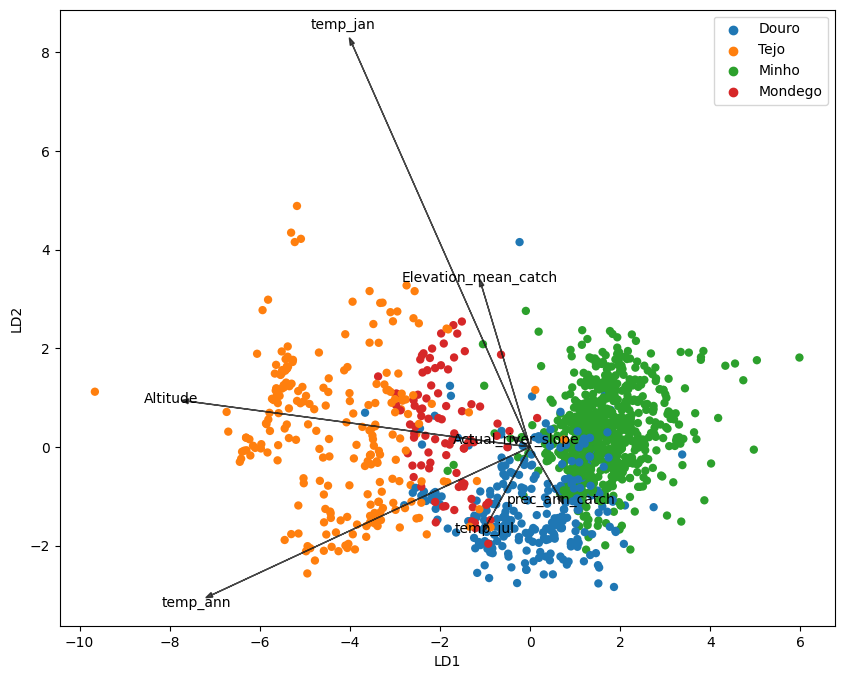

In [100]:
plt.figure(figsize=(10, 8))

sns.scatterplot(x=DLA_scores['LD1'],
              y=DLA_scores['LD2'],
              hue = dfsub['Catchment_name'].tolist(),
              linewidth=0,
              )

n = model.n_features_in_
for i in range(n):
        plt.arrow(0, 0, model.scalings_[i,0]*2, # Scalings were multiplied by a factor of 4 to just to facilitate the visualization
                  model.scalings_[i,1]*2, # Scalings were multiplied by a factor of 4 to just to facilitate the visualization
                  color = (0.1, 0.1, 0.1, 0.8),
                  head_width=0.1) # plot arrows for each variable
        plt.text(model.scalings_[i,0]*2.1, # plot the names of the variables
                 model.scalings_[i,1]*2.1,
                 list(df_scaled)[i], 
                 color = "black", 
                 ha = 'center', 
                 va = 'center') # variable labels for each arrow

plt.xlabel('LD1')
plt.ylabel('LD2')
plt.show()